# Kernels with `libpysal`


Kernel functions are widely used across spatial analysis for tasks such as density estimation, spatial smoothing, construction of local influence surfaces, and geographically weighted modeling. They provide a flexible mechanism to formalize how spatial influence decays with distance, allowing analysts to encode different assumptions about locality, neighborhood structure, and the scale of spatial interaction.

Within the PySAL ecosystem, kernel functions are used primarily for generating spatial weights matrices—especially continuous, distance-decay–based weights—and for defining weighted edges in spatial graph representations. They also appear in certain spatial econometric estimators that require localized or tapered weighting schemes to model distance-dependent interactions and spatial heterogeneity more realistically.

This notebook illustrates the functionality of kernels in  `libpysal`.


##  Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from libpysal import kernels

np.set_printoptions(precision=4, suppress=True)

##  Available Kernels

For a distance \(d\) and bandwidth \(h\), kernels are evaluated on the rescaled distance

\begin{equation}
z = \frac{d}{h}, \quad K(z).
\end{equation}

The following kernel functions are implemented using one-dimensional definitions with $K(z)=0$ outside the stated support:


- **Triangular** ("triangle")
  $$
  K(z) = 1 - |z|, \quad |z| \le 1.
  $$

- **Uniform** ("boxcar")
  $$
  K(z) = \frac{1}{2}, \quad |z| \le 1.
  $$

- **Quadratic** (Epanechnikov / "parabolic")
  $$
  K(z) = \frac{3}{4}(1 - z^2), \quad |z| \le 1.
  $$

- **Quartic** (biweight / "bisquare")
  $$
  K(z) = \frac{15}{16}(1 - z^2)^2, \quad |z| \le 1.
  $$

- **Gaussian**
  $$
  K(z) = (2\pi)^{-1/2} \exp\left(-\frac{z^2}{2}\right), \quad z \in \mathbb{R}.
  $$

The helpers in `kernels.py` adopt the same functional forms, but add optional arguments such as
`decay` and `taper` to control how quickly weights decline with distance and whether the kernel is
        truncated at the bandwidth.


### Interpretation of Kernel Functions

Kernel functions differ in smoothness, support, and rate of decay. These properties influence how local or global the resulting spatial weights are.

Triangular kernels decline linearly from peak to zero at the bandwidth. They generate moderate smoothing with sharp locality.

Uniform (boxcar) kernels assign equal weight to all neighbors within the bandwidth and zero beyond. This is equivalent to binary distance-band weights and does not provide smoothing inside the band.

Quadratic (parabolic) kernels decline smoothly and balance locality with smoothness. They are frequently used in nonparametric estimation due to favorable statistical properties.

Quartic (bisquare) kernels have a steeper decline and place more weight on very close neighbors while still providing smooth, compact support.

Gaussian kernels provide infinite support and the smoothest decay. Weights never drop to zero without tapering, which can lead to denser spatial weight matrices.

Compactly supported kernels yield sparse matrices and emphasize strict locality. Infinite-support kernels yield smoother influence but may require tapering for computational efficiency. The rate of decline determines how "local" the smoothing will be in practice.


Below we plot several common kernels implemented in `libpysal`.


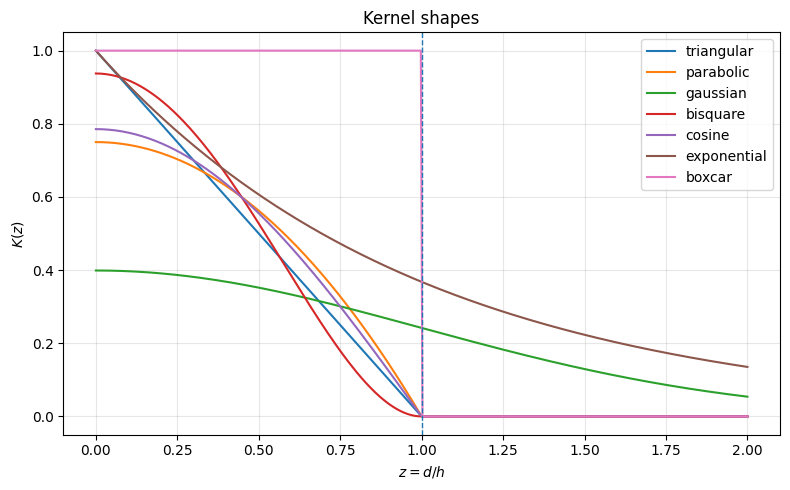

In [2]:
functions = [
    "triangular",
    "parabolic",
    "gaussian",
    "bisquare",
    "cosine",
    "exponential",
    "boxcar",
]

h = 1.0  # bandwidth
d = np.linspace(0, 2 * h, 400)

plt.figure(figsize=(8, 5))
for fn in functions:
    k = kernels.kernel(d, bandwidth=h, kernel=fn, taper=False)
    plt.plot(d / h, k, label=fn)

plt.axvline(1.0, linestyle="--", linewidth=1)
plt.xlabel("$z = d / h$")
plt.ylabel("$K(z)$")
plt.title("Kernel shapes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exploring alternative kernels and bandwidths

You can repeat the previous steps using different kernel functions and bandwidth strategies to see how they affect the spatial lag.

For example:

```python
w_gauss_fixed = Kernel(coords, k=8, fixed=True, function="gaussian")
w_gauss_fixed.transform = "r"
lag_gauss = lag_spatial(w_gauss_fixed, y)

# Plot `lag_gauss` and compare.
```

A typical set of experiments for a spatial analysis project might include:

- Trying different kernels (triangular, Gaussian, bisquare, etc.).
- Varying the number of neighbors `k`.
- Comparing fixed vs. adaptive bandwidth.
- Examining how these choices impact local statistics, regression residuals, or risk surfaces.


### Bandwidth

The `bandwidth` parameter controls the spatial scale of the kernel. In the notation used earlier, the
kernel is evaluated on the rescaled distance

\begin{equation}
z = \frac{d}{h},
\end{equation}

where `h` is the bandwidth. Smaller bandwidths produce more localized weights (steeper decay), while
larger bandwidths produce broader, smoother influence functions.

Below we compare triangular kernels with three different bandwidths on the same distance axis.


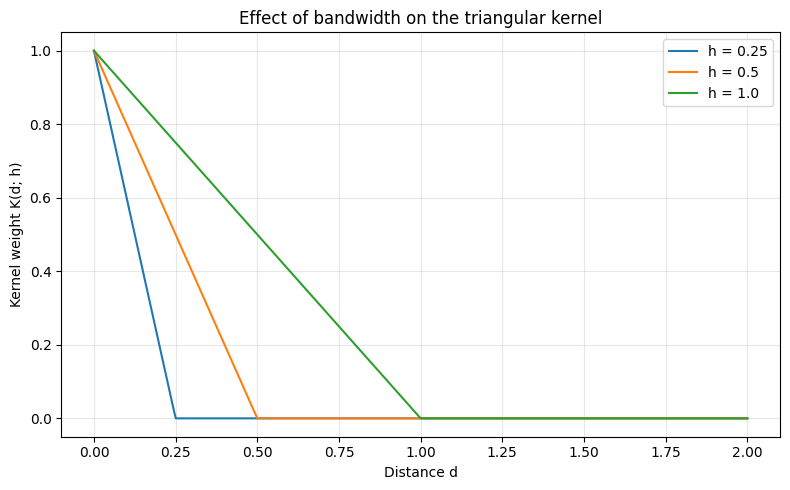

In [3]:
d = np.linspace(0, 2, 400)  # absolute distance
bandwidths = [0.25, 0.5, 1.0]

plt.figure(figsize=(8, 5))
for h in bandwidths:
    k_vals = kernels.kernel(d, bandwidth=h, kernel="triangular", taper=False)
    plt.plot(d, k_vals, label=f"h = {h}")

plt.xlabel("Distance d")
plt.ylabel("Kernel weight K(d; h)")
plt.title("Effect of bandwidth on the triangular kernel")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Decay

For the Gaussian kernel, the `decay` argument determines whether to calculate the kernel using the decay formulation.
        In the decay form, a kernel measures the distance decay in
        similarity between observations. It varies from  maximal
        similarity (1) at a distance of zero to minimal similarity (0
        or negative) at some very large (possibly infinite) distance.
        Otherwise, kernel functions are treated as proper
        volume-preserving probability distributions.


Here we fix the bandwidth and compare Gaussian kernels with different `decay` values.


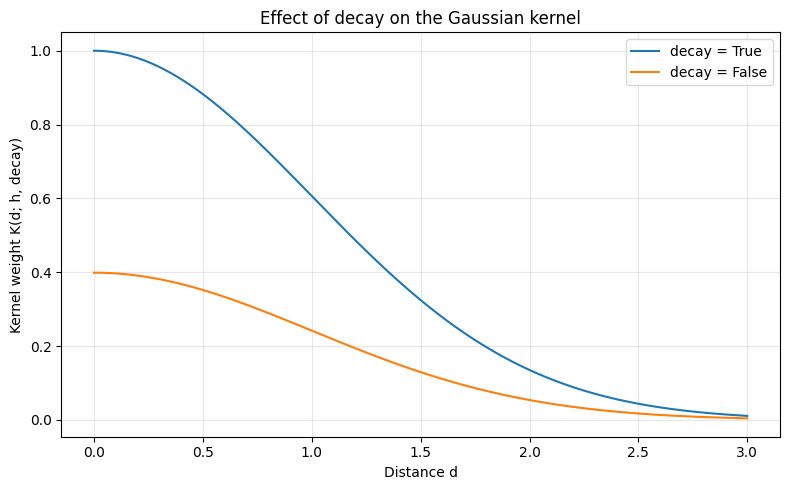

In [4]:
d = np.linspace(0, 3, 400)
h = 1.0
decays = [True, False]

plt.figure(figsize=(8, 5))
for dec in decays:
    k_vals = kernels.kernel(d, bandwidth=h, kernel="gaussian", decay=dec, taper=False)
    plt.plot(d, k_vals, label=f"decay = {dec}")

plt.xlabel("Distance d")
plt.ylabel("Kernel weight K(d; h, decay)")
plt.title("Effect of decay on the Gaussian kernel")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Taper

The `taper` argument is particularly relevant for unbounded kernels (e.g., Gaussian, exponential).
When `taper=False`, the kernel has non-zero weight at all distances (in principle), although weights
may become very small. When `taper=True`, the kernel is truncated at the bandwidth `h`, so weights
are exactly zero for `d > h`. When `taper=c`, where `c` is a numeric value (float or int), 
the kernel is truncated at that specific distance threshold, so weights are exactly zero for `d > c`.

This can make the resulting spatial weights matrix sparser and improve computational efficiency,
while still preserving the basic shape of the kernel within the bandwidth.

Below we compare a Gaussian kernel with and without tapering.


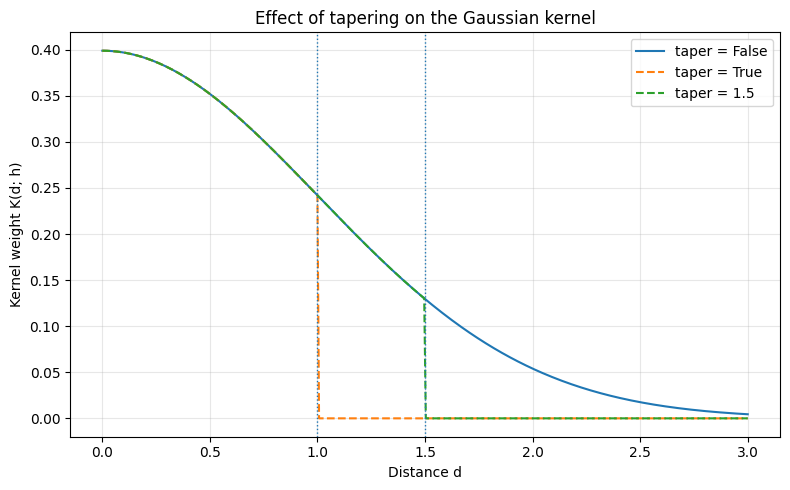

In [10]:
d = np.linspace(0, 3, 400)
h = 1.0
c = 1.5

k_notaper = kernels.kernel(d, bandwidth=h, kernel="gaussian", taper=False)
k_taper = kernels.kernel(d, bandwidth=h, kernel="gaussian", taper=True)
k_taper_custom = kernels.kernel(d, bandwidth=h, kernel="gaussian", taper=c)

plt.figure(figsize=(8, 5))
plt.plot(d, k_notaper, label="taper = False")
plt.plot(d, k_taper, linestyle="--", label="taper = True")
plt.plot(d, k_taper_custom, linestyle="--", label="taper = 1.5")
plt.axvline(h, linestyle=":", linewidth=1)
plt.axvline(c, linestyle=":", linewidth=1)

plt.xlabel("Distance d")
plt.ylabel("Kernel weight K(d; h)")
plt.title("Effect of tapering on the Gaussian kernel")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()